# Basic usage Array1DScanAnalyzer

This notebook demonstrates the basic intended usage of Array1DScanAnalyzer. This object is meant as a compliment to ImageAnalysis to manage and perform ImageAnalysis functionality across a scan focusing on data that is either stored as x vs y data, or converted to x vs y data from an iamge. It has much of the sam functionalithy as Array2DAnalyzer, but with slightly different postprocessing pipelines allowign for creation  waterfall plots. See that example for additional details

In [1]:
import logging
import time

from IPython.display import Image, display
from pathlib import Path

from geecs_data_utils import ScanPaths, ScanTag
from scan_analysis.base import ScanAnalyzerInfo as Info
from scan_analysis.execute_scan_analysis import instantiate_scan_analyzer
from scan_analysis.analyzers.common.array1d_scan_analysis import Array1DScanAnalyzer

# import the desired ImageAnalyzer
from image_analysis.offline_analyzers.standard_1d_analyzer import Standard1DAnalyzer

# BeamAnalyzer uses a configuration file for instantiation and use. So,
# we need to set the config path. But, any type of ImageAnalzyer can be used.
from image_analysis.config_loader import set_config_base_dir

# Set the logging level. Can set to INFO or DEBUG to get more detail about the
# actual execution
logging.getLogger("image_analysis").setLevel(logging.ERROR)
logging.getLogger("scan_analysis").setLevel(logging.ERROR)
logging.getLogger("geecs_data_utils").setLevel(logging.ERROR)
logging.getLogger("logmaker_4_googledocs").setLevel(logging.ERROR)


set_config_base_dir(ScanPaths.paths_config.image_analysis_configs_path)


2025-10-14 10:36:34,535 - scan_analysis.execute_scan_analysis - WARNING - Docgen import failed ('script'); disabling.


Failed to load config file from: D:\Users\sbarber.BELLAAPPSERVER\Documents\GitHub\GEECS-Plugins\LogMaker4GoogleDocs\logmaker_4_googledocs\config.ini


Instantiate the ImageAnalyzer. Note, here the device name is also used to point to a configuration yaml file found in teh 'config_base_dir' set above. Important scan_analyzer_kwargs to be aware of:

'file_tail' defaults to ".png". It's not necessarily the file extestion as it can be used to include 'non standard' ways, like '-interpSpec.txt'

'analysis_mode' defaults to 'per_shot'. Can be 'per_bin'. This determines if the 'analyze_image' is applied on a shot-by-shot basis or on the average image of each bin

'renderer_kwargs' are a set of of kwargs that can be used to fine tune the creation of the graphics


execution time: 9.563000000081956


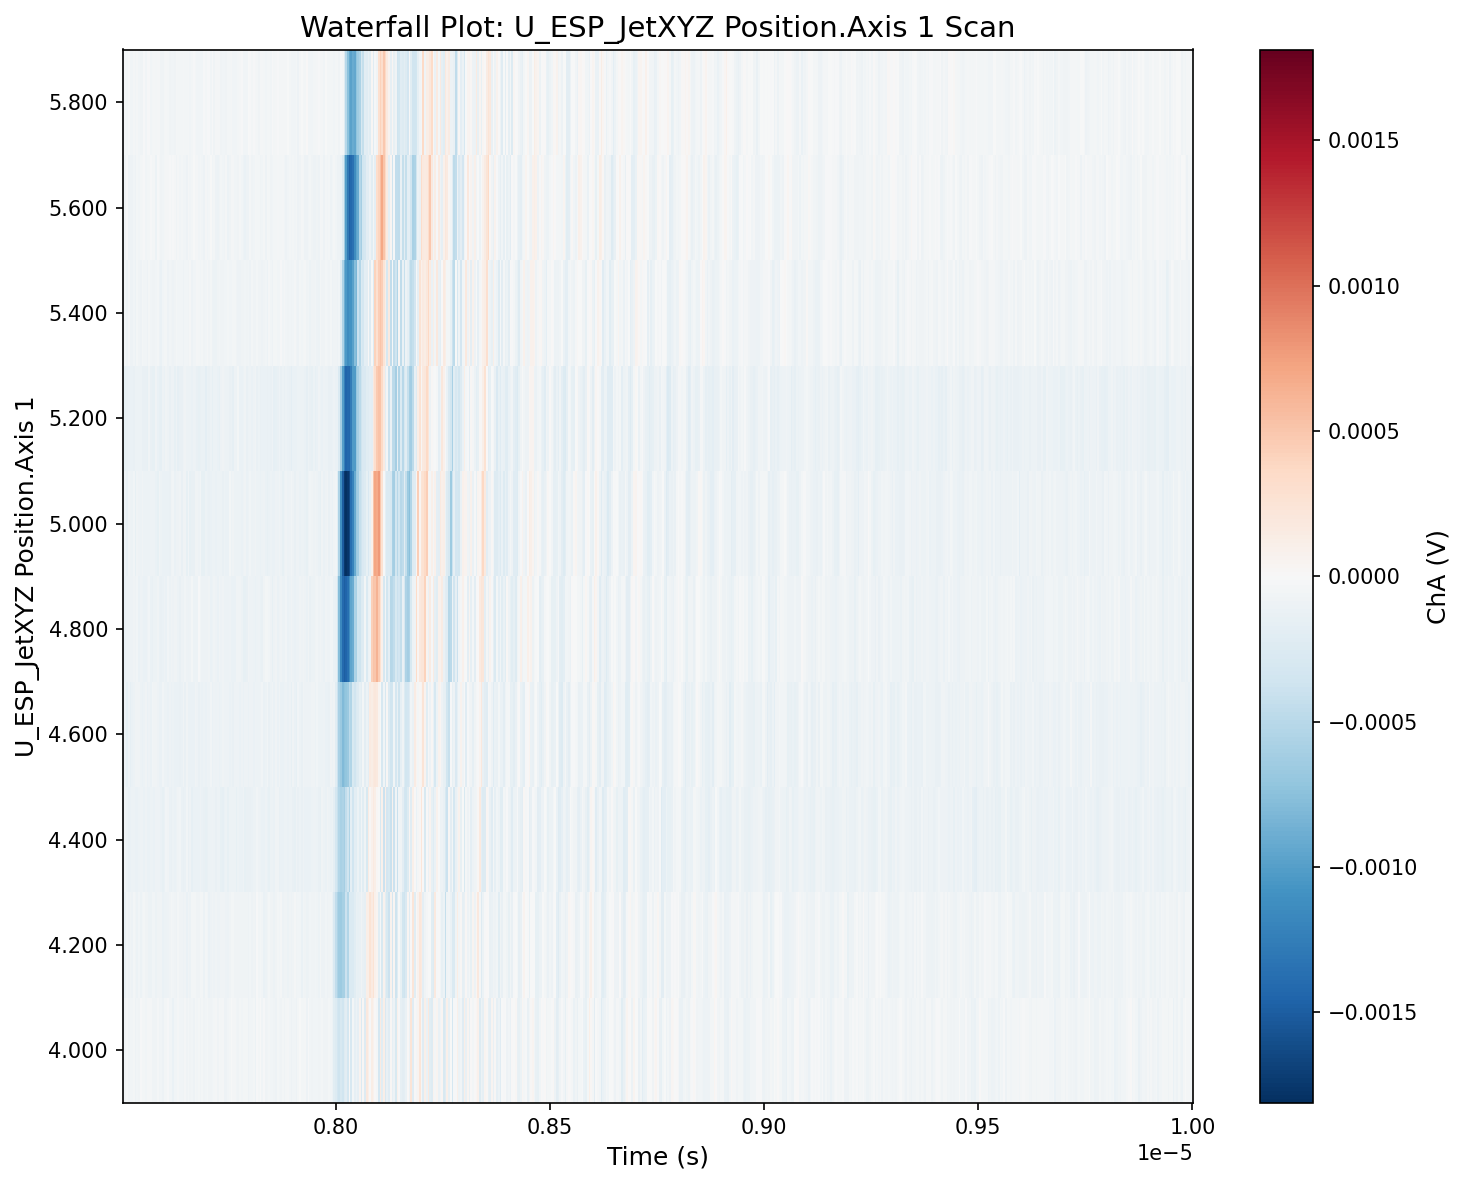

In [2]:
t0 = time.monotonic()

# ScanAnalyzers use ScanTag as an arg, which is a unique identifier, to
# determine which scan to process
year = 2025
month = 9
day = 24
number = 8
experiment = "Undulator"

test_tag = ScanTag(
    year=year, month=month, day=day, number=number, experiment=experiment
)

dev_name = "U_BCaveICT"
image_analyzer = Standard1DAnalyzer(line_config_name=dev_name)


# Create an scan_analyzer_info which is used to directly instantiate the
# ScanAnalyzer (which is an Array2DScanAnalyzer in this case)
scan_analyzer_info = Info(
    scan_analyzer_class=Array1DScanAnalyzer,
    requirements={dev_name},
    device_name=dev_name,
    scan_analyzer_kwargs={
        "image_analyzer": image_analyzer,
        "analysis_mode": "per_shot",
        "file_tail": ".tdms",
        "renderer_kwargs": {
            "colormap_mode": "diverging",  # For scope traces with +/- signals
            "cmap": "RdBu_r",
        },
    },
)

scan_analyzer = instantiate_scan_analyzer(scan_analyzer_info=scan_analyzer_info)
scan_analyzer.flag_save_data = True

# run the analysis
result = scan_analyzer.run_analysis(scan_tag=test_tag)

t1 = time.monotonic()
print(f"execution time: {t1 - t0}")
display(Image(filename=str(result[0]), width=500))

When the execution is complete, we can inspect indivdiual images

execution time: 29.280999999959022


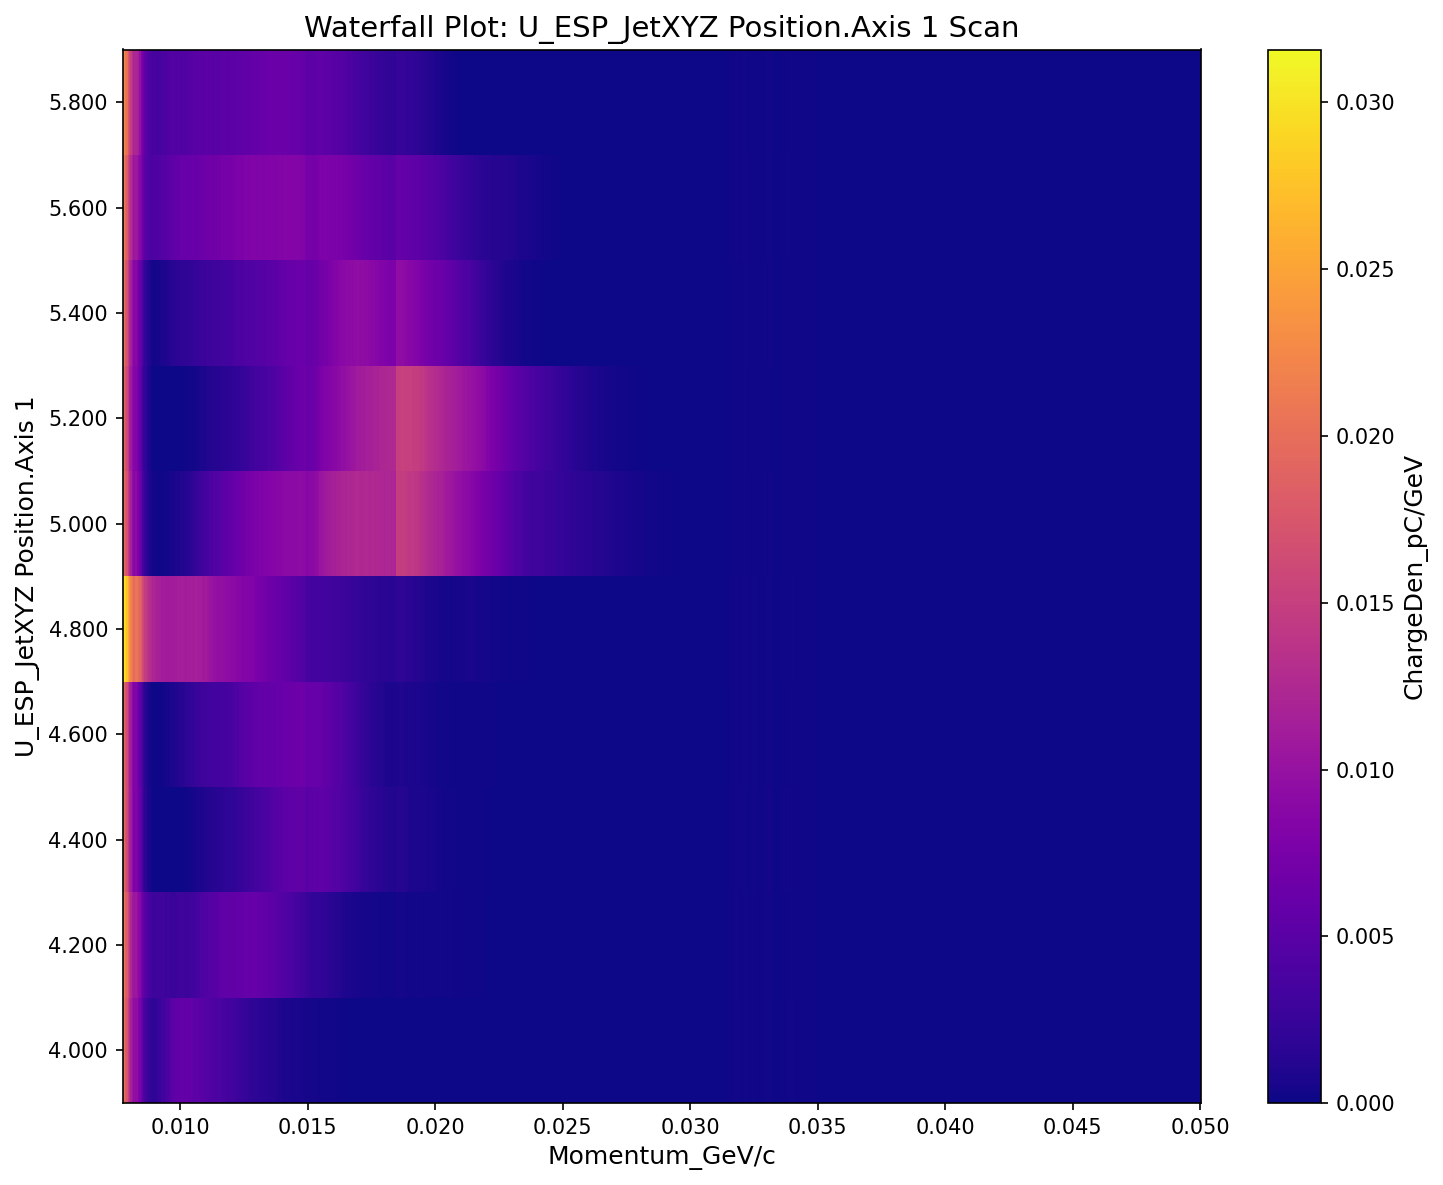

In [3]:
t0 = time.monotonic()

dev_name = "U_BCaveMagSpec-interpSpec"
image_analyzer_mag = Standard1DAnalyzer(line_config_name=dev_name)

scan_analyzer_info_mag = Info(
    scan_analyzer_class=Array1DScanAnalyzer,
    requirements={dev_name},
    device_name=dev_name,
    scan_analyzer_kwargs={
        "image_analyzer": image_analyzer_mag,
        "file_tail": ".txt",
    },
)

scan_analyzer_mag = instantiate_scan_analyzer(scan_analyzer_info=scan_analyzer_info_mag)
scan_analyzer_mag.flag_save_data = True

# run the analysis
result = scan_analyzer_mag.run_analysis(scan_tag=test_tag)
t1 = time.monotonic()
print(f"execution time: {t1 - t0}")
display(Image(filename=str(result[0]), width=500))


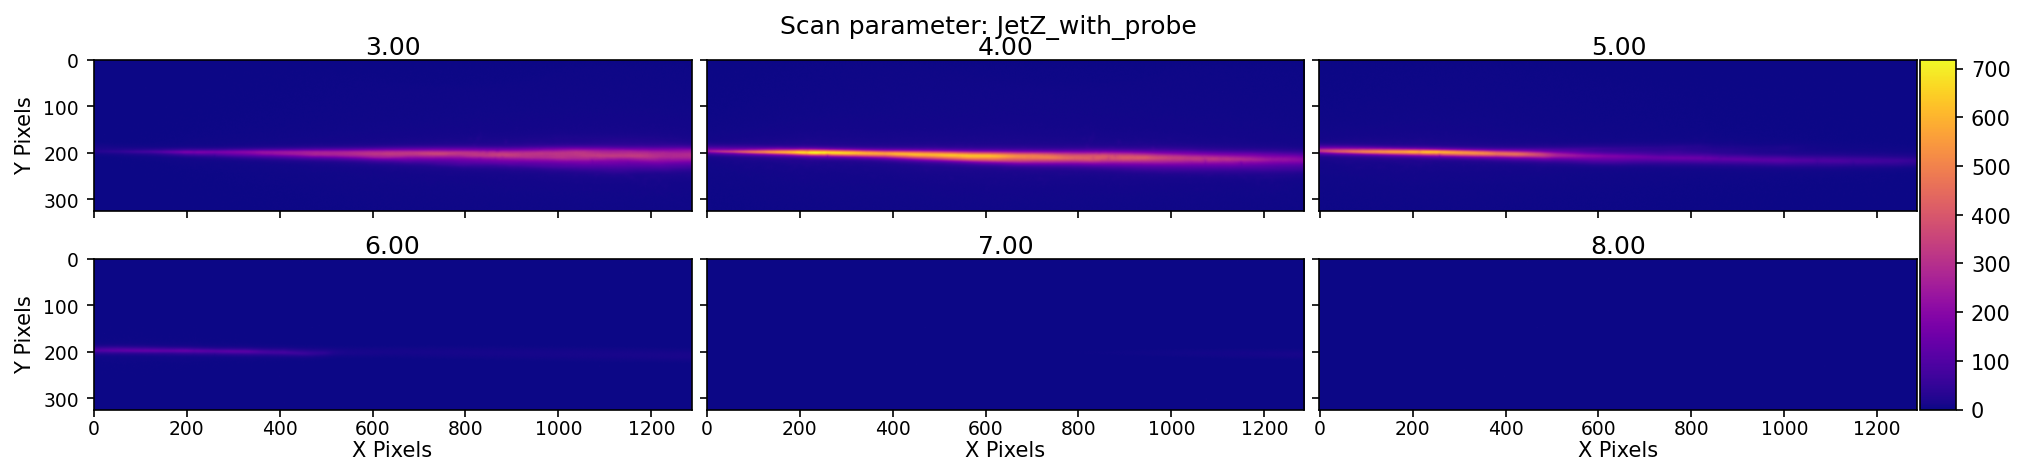

In [4]:
from image_analysis.offline_analyzers.Undulator.hi_res_mag_cam_analyzer import (
    HiResMagCamAnalyzer,
)
from scan_analysis.analyzers.common.array2D_scan_analysis import Array2DScanAnalyzer


analyzer_info = Info(
    scan_analyzer_class=Array2DScanAnalyzer,
    requirements={"UC_HiResMagCam"},
    device_name="UC_HiResMagCam",
    scan_analyzer_kwargs={
        "image_analyzer": HiResMagCamAnalyzer(camera_config_name="UC_HiResMagCam")
    },
)

test_tag = ScanTag(year=2025, month=8, day=19, number=2, experiment="Undulator")

test_analyzer = instantiate_scan_analyzer(analyzer_info)

result = test_analyzer.run_analysis(scan_tag=test_tag)
display(Image(filename=str(result[0]), width=500))

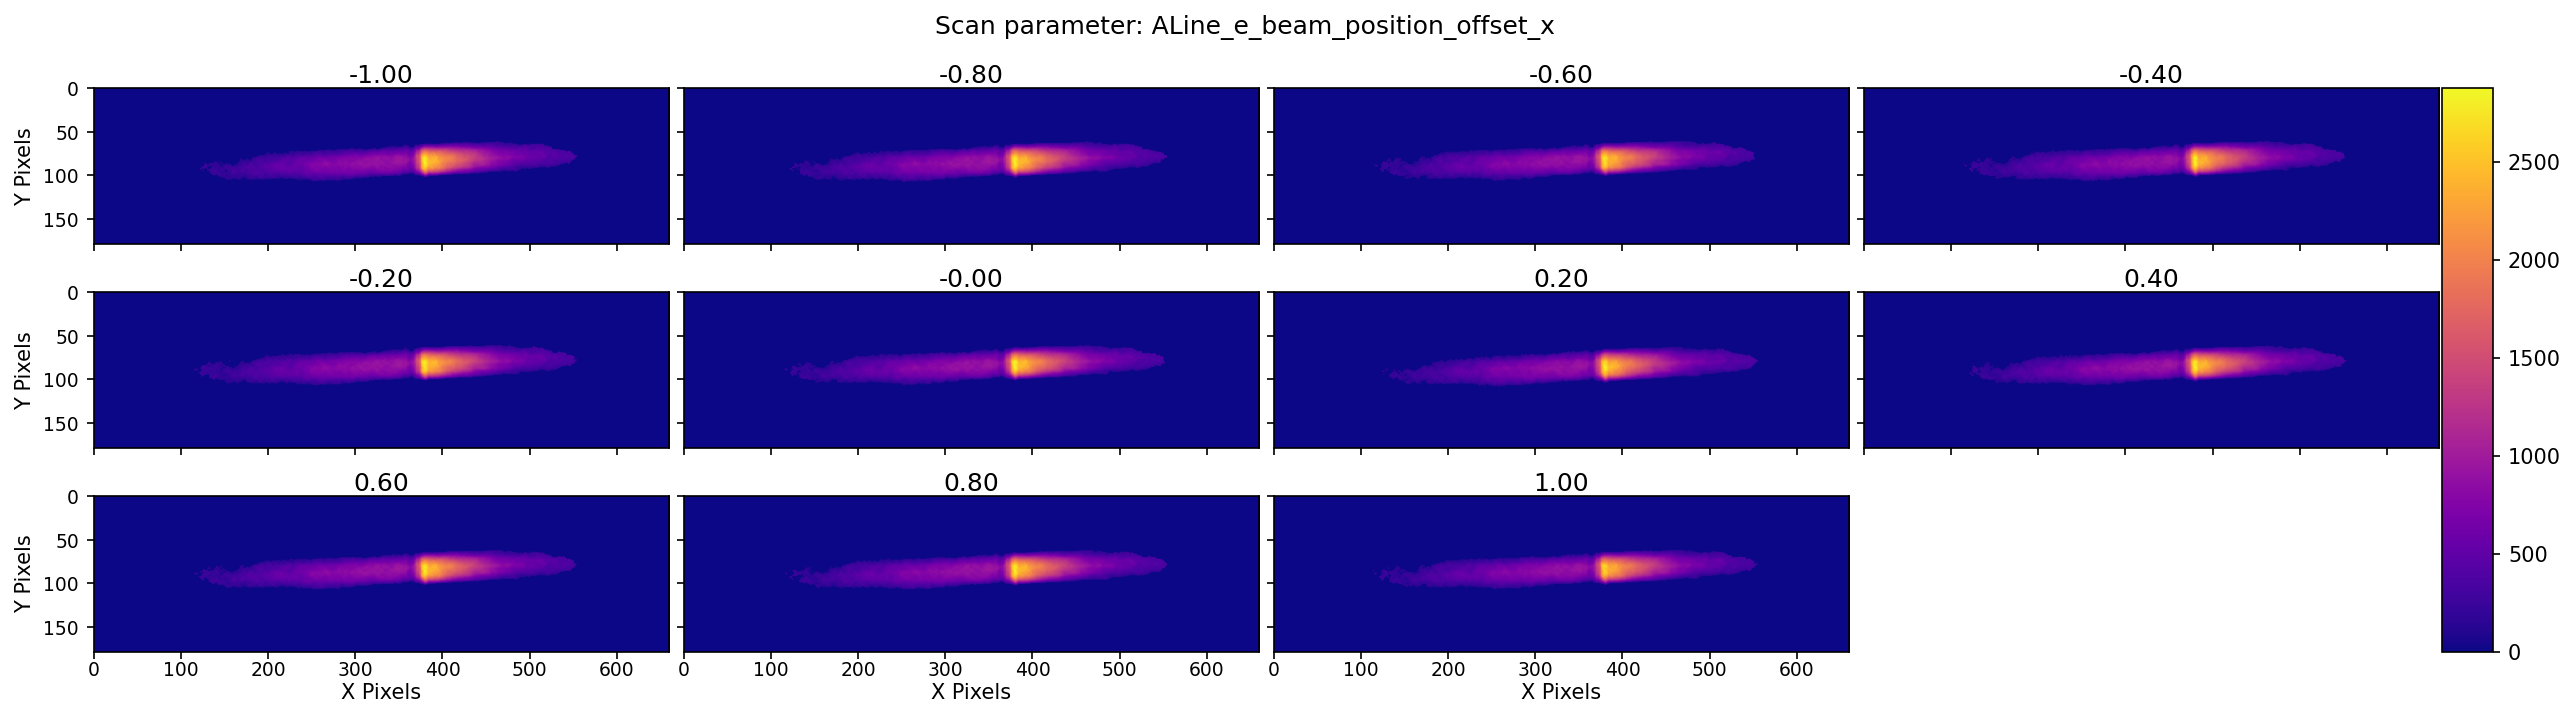

In [5]:
from image_analysis.offline_analyzers.density_from_phase_analysis import (
    PhaseAnalysisConfig,
    PhaseDownrampProcessor,
)
from scan_analysis.analyzers.common.array2D_scan_analysis import Array2DScanAnalyzer

from geecs_data_utils import ScanData, ScanTag
from dataclasses import asdict


def get_path_to_bkg_file():
    """Get path to bkd."""
    st = ScanTag(year=2025, month=3, day=6, number=15, experiment="Undulator")
    sp = ScanPaths(tag=st)
    s_data = ScanData(paths=sp)
    path_to_file = s_data.paths.get_folder() / "U_HasoLift" / "average_phase.tsv"

    return path_to_file


bkg_file_path = get_path_to_bkg_file()
config: PhaseAnalysisConfig = PhaseAnalysisConfig(
    pixel_scale=10.1,  # um per pixel (vertical)
    wavelength_nm=800,  # Probe laser wavelength in nm
    threshold_fraction=0.05,  # Threshold fraction for pre-processing
    roi=(10, -10, 75, -250),  # Example ROI: (x_min, x_max, y_min, y_max)
    background_path=bkg_file_path,  # Background is now a Path
)
config_dict = asdict(config)
analyzer_info = Info(
    scan_analyzer_class=Array2DScanAnalyzer,
    requirements={"U_HasoLift"},
    device_name="U_HasoLift",
    scan_analyzer_kwargs={
        "image_analyzer": PhaseDownrampProcessor(**config_dict),
        "analysis_mode": "per_bin",
        "file_tail": "_postprocessed.tsv",
    },
)

test_analyzer = instantiate_scan_analyzer(analyzer_info)

test_tag = ScanTag(year=2025, month=3, day=6, number=16, experiment="Undulator")
result = test_analyzer.run_analysis(scan_tag=test_tag)
display(Image(filename=str(result[0]), width=500))

execution time: 8.984000000171363


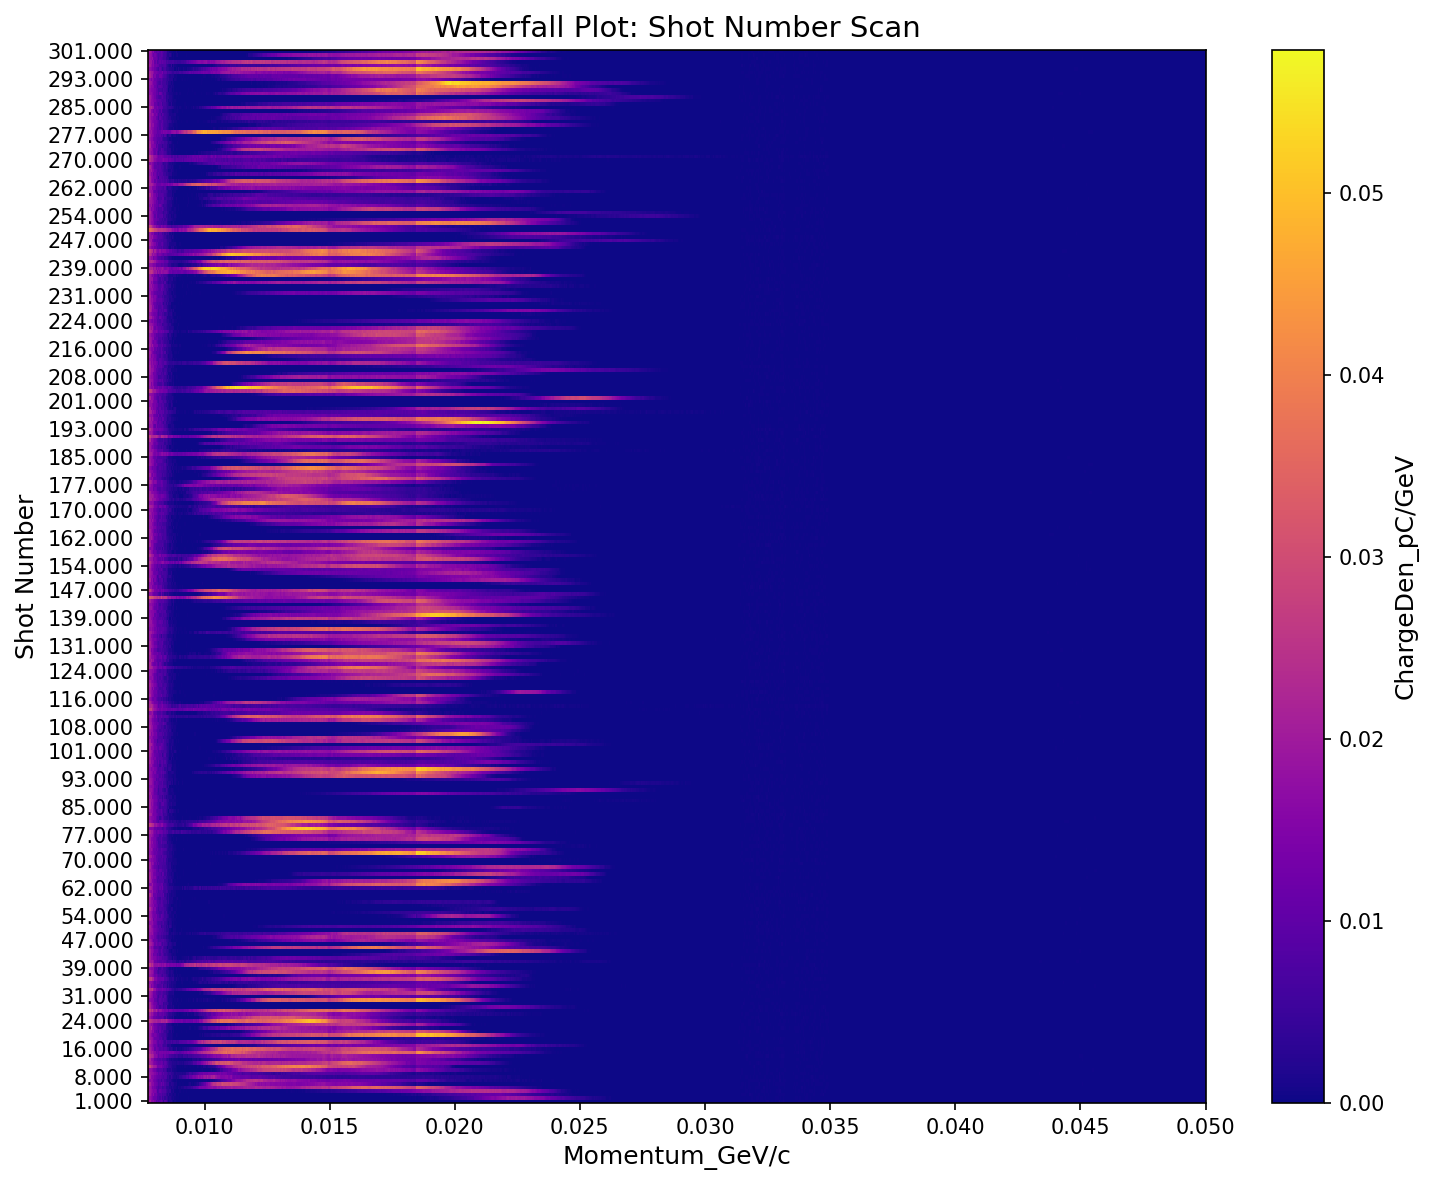

In [6]:
t0 = time.monotonic()

year = 2025
month = 9
day = 24
number = 10
experiment = "Undulator"

test_tag = ScanTag(
    year=year, month=month, day=day, number=number, experiment=experiment
)

dev_name = "U_BCaveMagSpec-interpSpec"
image_analyzer_mag = Standard1DAnalyzer(line_config_name=dev_name)

scan_analyzer_info_mag = Info(
    scan_analyzer_class=Array1DScanAnalyzer,
    requirements={dev_name},
    device_name=dev_name,
    scan_analyzer_kwargs={
        "image_analyzer": image_analyzer_mag,
        "analysis_mode": "per_shot",
        "file_tail": ".txt",
    },
)

scan_analyzer_mag = instantiate_scan_analyzer(scan_analyzer_info=scan_analyzer_info_mag)
scan_analyzer_mag.flag_save_data = True

# run the analysis
result = scan_analyzer_mag.run_analysis(scan_tag=test_tag)
t1 = time.monotonic()
print(f"execution time: {t1 - t0}")
display(Image(filename=str(result[0]), width=500))

Note: Array1DAnalyzer can be used in conjunction with a with an ImageAnalyzer designed to process 2D images that converts the 2D image into 1D type data. For example, a homebuilt optical spectrometer that uses a CCD. For this to work, the y vs x data is passed to the return_lineouts and the 'processed_image' is left blank. 